In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error

from sklearn.linear_model import Ridge

In [2]:
df = pd.read_csv("parkade_data/processed_thunderbird_2014.csv", parse_dates=["TimestampLocal"])
df = df.rename(columns={'TimestampLocal': 'Timestamp', 'TimestampLocal.total_count': 'total_count'})
df.head(10)

,Timestamp,total_count,parkade
0,2014-01-01,52,Thunderbird
1,2014-01-02,119,Thunderbird
2,2014-01-03,705,Thunderbird
3,2014-01-04,874,Thunderbird
4,2014-01-05,579,Thunderbird
5,2014-01-06,681,Thunderbird
6,2014-01-07,316,Thunderbird
7,2014-01-08,254,Thunderbird
8,2014-01-09,1386,Thunderbird
9,2014-01-10,1571,Thunderbird


In [3]:
print(df["Timestamp"].min())
print(df["Timestamp"].max())

2014-01-01 00:00:00
2023-02-02 00:00:00


In [4]:
def get_season(month):
    SUMMER_MONTHS = [6, 7, 8] 
    SPRING_MONTHS = [3, 4, 5]
    WINTER_MONTHS = [12, 1, 2]
    FALL_MONTHS = [9, 10, 11]
    if month in WINTER_MONTHS:
        return "Winter"
    elif month in FALL_MONTHS:
        return "Autumn"
    elif month in SUMMER_MONTHS:
        return "Summer"
    else:
        return "Fall"

In [5]:
def get_school_term(month):
    SUMMER_TERM = [5, 6, 7, 8]
    WINTER_TERM = [9, 10, 11, 12]
    SPRING_TERM = [1, 2, 3, 4]
    
    if month in SUMMER_TERM:
        return "Summer_term"
    elif month in WINTER_TERM:
        return "Winter_term"
    else:
        return "Spring_term"

In [6]:
def create_lag_df(df, lag, cols):
    return df.assign(
        **{f"{col}_{n}_days_ago": df[col].shift(n) for n in range(1, lag + 1) for col in cols}
    )

In [7]:
df['year'] = pd.DatetimeIndex(df['Timestamp']).year
df['month'] = pd.DatetimeIndex(df['Timestamp']).month
df['day'] = pd.DatetimeIndex(df['Timestamp']).day
df['day_of_week'] = pd.DatetimeIndex(df['Timestamp']).day_name()
df = df.assign(season=df["month"].apply(get_season))
df = df.assign(term=df["month"].apply(get_school_term))
df = create_lag_df(df, 7, ['total_count'])

In [8]:
# processed_thunderbird_2014.csv, dropped covid data splits
# 80-20 split
split_date = "2020-01-03 0:00"
# 90-10 split
# split_date = "2022-08-22 0:00"

df_train = df[df["Timestamp"] <= split_date]
df_test = df[df["Timestamp"] > split_date]
assert(len(df_train) + len(df_test) == len(df))

print(df_train.shape)
print(df_test.shape)

(2194, 16)
(1126, 16)


In [9]:
# Reference: https://ubc-cs.github.io/cpsc330/lectures/20_time-series.html
def preprocess_features(
    train_df,
    test_df,
    numeric_features,
    categorical_features,
    drop_features,
    target
):

    all_features = set(numeric_features + categorical_features + drop_features + target)
    
    if set(train_df.columns) != all_features:
        print("Missing columns", set(train_df.columns) - all_features)
        print("Extra columns", all_features - set(train_df.columns))
        raise Exception("Columns do not match")

    # Apply imputation and scaling to numerical features 
    numeric_transformer = make_pipeline(
        SimpleImputer(strategy="median"), StandardScaler()
    )
    
    # Apply imputation and One-Hot encoding to categorical features
    categorical_transformer = make_pipeline(
        SimpleImputer(strategy="constant", fill_value="missing"),
        OneHotEncoder(handle_unknown="ignore", sparse_output=False),
    )
    
    # Define a column transformer
    preprocessor = make_column_transformer(
        (numeric_transformer, numeric_features),
        (categorical_transformer, categorical_features),
        ("drop", drop_features),
    )
    
    preprocessor.fit(train_df)
    ohe_feature_names = (
        preprocessor.named_transformers_["pipeline-2"]
        .named_steps["onehotencoder"]
        .get_feature_names_out(categorical_features)
        .tolist()
    )
    new_columns = numeric_features + ohe_feature_names

    X_train_enc = pd.DataFrame(
        preprocessor.transform(train_df), index=train_df.index, columns=new_columns
    )
    X_test_enc = pd.DataFrame(
        preprocessor.transform(test_df), index=test_df.index, columns=new_columns
    )

    y_train = train_df["total_count"]
    y_test = test_df["total_count"]

    return X_train_enc, y_train, X_test_enc, y_test, preprocessor

In [10]:
# Categorize and preprocess features
numeric_features = ["year", "month", "day", "total_count_1_days_ago", "total_count_2_days_ago", "total_count_3_days_ago", 
                    "total_count_4_days_ago", "total_count_5_days_ago", "total_count_6_days_ago", "total_count_7_days_ago"]
categorical_features = ["day_of_week", "season", "term"]
# drop_features = ["Timestamp"]
drop_features = ["Timestamp", "parkade"]
target = ["total_count"]

X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(
    df_train,
    df_test,
    numeric_features,
    categorical_features,
    drop_features,
    target
)

X_train_enc.head(5)

,year,month,day,total_count_1_days_ago,total_count_2_days_ago,total_count_3_days_ago,total_count_4_days_ago,total_count_5_days_ago,total_count_6_days_ago,total_count_7_days_ago,...,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,season_Autumn,season_Fall,season_Summer,season_Winter,term_Spring_term,term_Summer_term,term_Winter_term
0,-1.46363,-1.597986,-1.669929,-0.222904,-0.222721,-0.222591,-0.222432,-0.2222,-0.222795,-0.223449,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,-1.46363,-1.597986,-1.556389,-1.589380,-0.222721,-0.222591,-0.222432,-0.2222,-0.222795,-0.223449,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,-1.46363,-1.597986,-1.442849,-1.472900,-1.590741,-0.222591,-0.222432,-0.2222,-0.222795,-0.223449,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,-1.46363,-1.597986,-1.329309,-0.454127,-1.474203,-1.592239,-0.222432,-0.2222,-0.222795,-0.223449,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,-1.46363,-1.597986,-1.215769,-0.160317,-0.454928,-1.475637,-1.593661,-0.2222,-0.222795,-0.223449,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [11]:
# Create Ridge pipe
ridge_pipe = make_pipeline(preprocessor, Ridge())
ridge_pipe.fit(df_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['year', 'month', 'day',
                                                   'total_count_1_days_ago',
                                                   'total_count_2_days_ago',
                                                   'total_count_3_days_ago',
                                                   'total_count_4_days_ago',
                                                   'total_count_5_days_ago',
                                                   'total_count_6_days_ago',
                                                   'total_count_7_days_ago']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['day_of_week', 'season',
                                                   'term']),
                                                 ('drop', 'drop',
                                                  ['Timestamp', 'parkade'])])),
                ('ridge', Ridge())])

In [16]:
# Final model performance
print("R^2 score on training set: {:.3f}".format(r2_score(y_train, ridge_pipe.predict(df_train))))
print("R^2 score on test set: {:.3f}".format(r2_score(y_test, ridge_pipe.predict(df_test))))
print("Mean Absolute Percentage Error on training set: {:.3f}%".format(mean_absolute_percentage_error(y_train, ridge_pipe.predict(df_train)) * 100))
print("Mean Absolute Percentage Error on testing set: {:.3f}%".format(mean_absolute_percentage_error(y_test, ridge_pipe.predict(df_test)) * 100))
print("Mean Absolute Error on training set: {:.0f}".format(mean_absolute_error(y_train, ridge_pipe.predict(df_train))))
print("Mean Absolute Error on testing set: {:.0f}".format(mean_absolute_error(y_test, ridge_pipe.predict(df_test))))

R^2 score on training set: 0.537
R^2 score on test set: 0.607
Mean Absolute Percentage Error on training set: 55.344%
Mean Absolute Percentage Error on testing set: 50.210%
Mean Absolute Error on training set: 280
Mean Absolute Error on testing set: 248


**Metrics** 

| Category | R^2 | MAE | MAPE |
| -------- | --------- | ------ | -------- |
| Training | 0.537 | 280 | 55.344% |   
| Test | 0.607 | 248 | 50.210% |  

In [13]:
y_test_and_pred = df_test.loc[2801:, ["total_count"]]
y_test_and_pred["prediction"] = ridge_pipe.predict(df_test.loc[2801:]).tolist()
y_test_and_pred["Date"] = pd.DatetimeIndex(df_test.loc[2801:]["Timestamp"]).date
print(y_test_and_pred)

      total_count   prediction        Date
2801          737  1105.800448  2021-09-02
2802         1257  1238.218372  2021-09-03
2803          181  1045.891648  2021-09-04
2804          233   774.367445  2021-09-05
2805         1397   903.627356  2021-09-06
...           ...          ...         ...
3315          612   779.998523  2023-01-29
3316         1678  1282.813867  2023-01-30
3317         1583  1692.610539  2023-01-31
3318         1824  1665.307710  2023-02-01
3319         1513  1682.200206  2023-02-02

[519 rows x 3 columns]


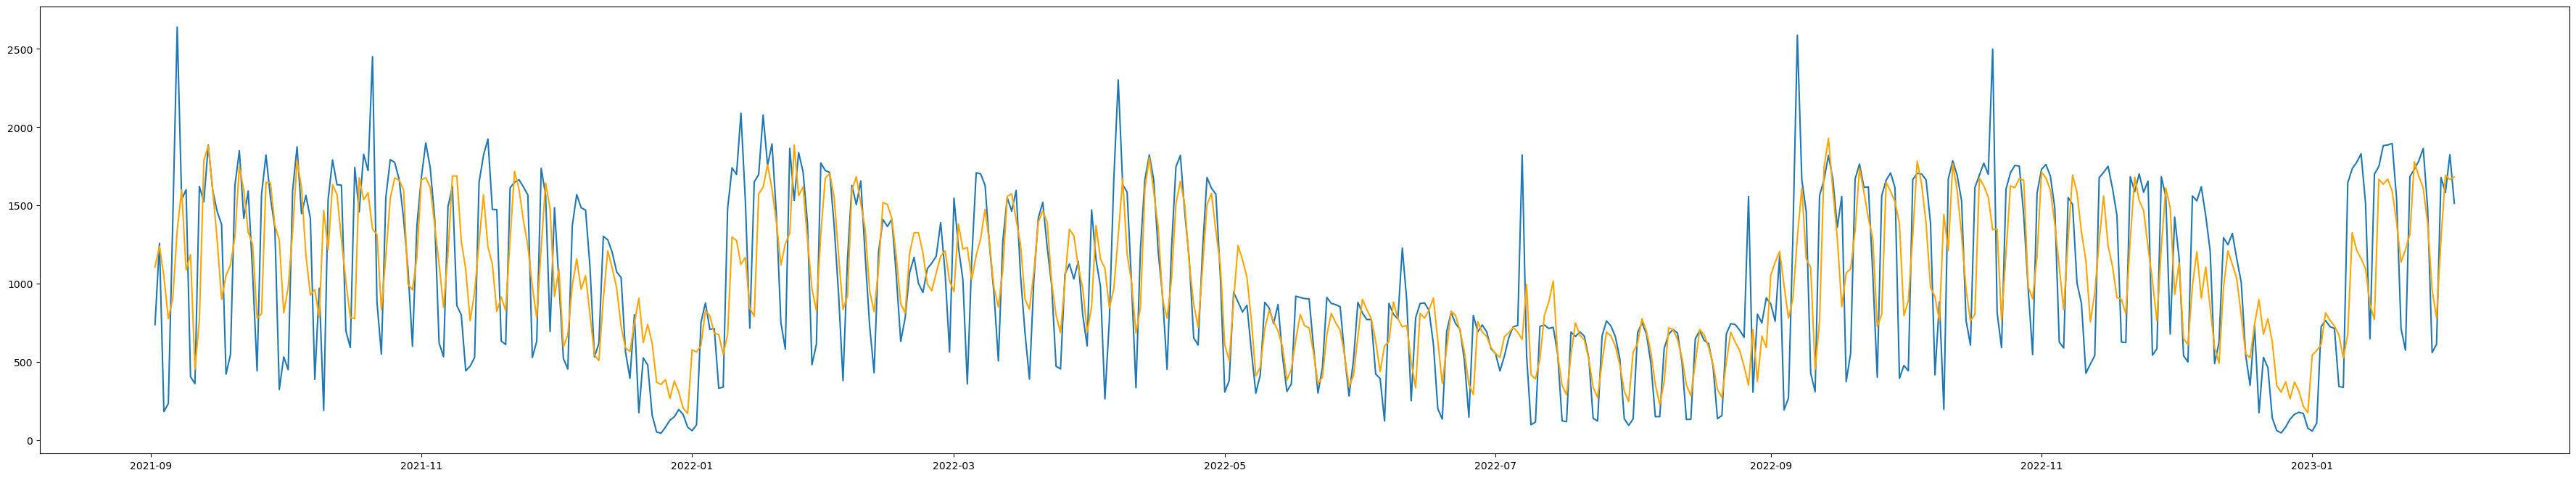

In [14]:
plt.figure(figsize=(45, 8))
plt.plot(y_test_and_pred["Date"], y_test_and_pred["total_count"])
plt.plot(y_test_and_pred["Date"], y_test_and_pred["prediction"], color="orange")